In [ ]:
from grade_classif.imports import *
from grade_classif.params.parser import hparams
from grade_classif.models.plmodules import *
from grade_classif.data.read import get_files
from grade_classif.data.loaders import ImageLoader
from grade_classif.data.utils import np_to_tensor
from grade_classif.data.transforms import get_transforms1
from grade_classif.data.modules import *
from grade_classif.data.dataset import TestDataset
from skimage.color import rgb2hed, rgb2hsv, hsv2rgb
from torch.utils.data import Dataset, DataLoader
from fastcore.foundation import L
from openslide import OpenSlide
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from albumentations.augmentations.functional import resize
from sklearn.metrics import auc
from pytorch_lightning.metrics import ROC, ConfusionMatrix
from grade_classif.models.metrics import ClassifMetrics
import PIL.Image as Image
from math import ceil
from torchvision.transforms.functional import to_tensor, to_pil_image

In [ ]:
files = get_files("/data/DeepLearning/SCHWOB_Robin/Patches_cancer_1024/Patches_cancer_1024_1", extensions=[".png"])

In [ ]:
device = "cuda:0"
norm = torch.jit.load(
    "/data/DeepLearning/SCHWOB_Robin/models/logs/level_1/normalizer/cgr_5_32_4/lightning_logs/version_146e3f332e7f404f95e4afc4f96fc5ab/27.pt",
    map_location=device,
).eval()
for p in norm.parameters():
    p.requires_grad = False

In [ ]:
pacs_files = {}
for pacs in ("04", "05", "08"):
    l = []
    for f in files:
        if f"PACS{pacs}" in f.stem:
            l.append(f)
    pacs_files[pacs] = np.array(l)

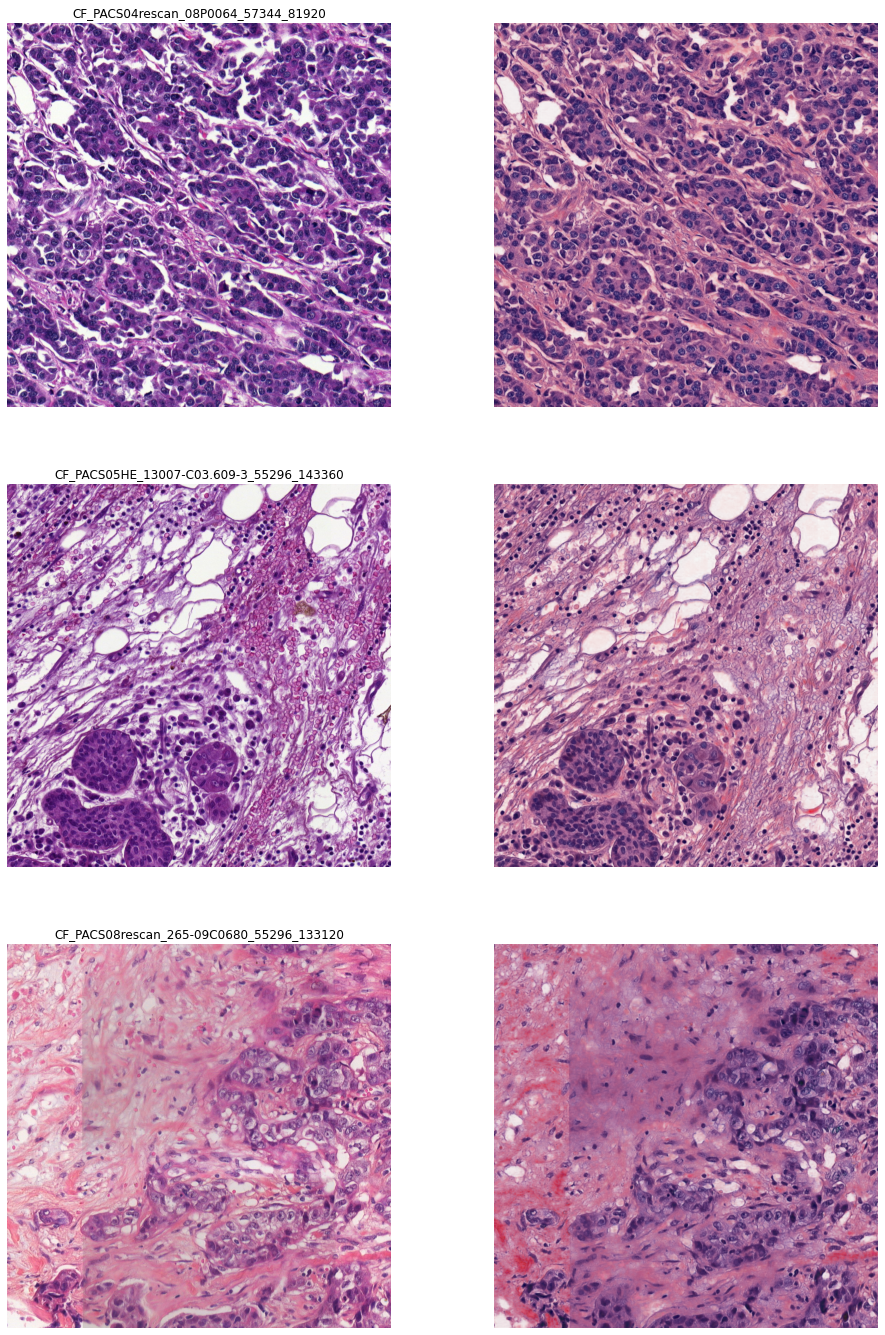

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(16, 24))
for k, pacs in enumerate(pacs_files):
    x = []
    for ax in axs[k : (k + 1), 0]:
        f = np.random.choice(pacs_files[pacs])
        img = imread(f)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f.stem)
        img = np_to_tensor(img.astype(np.float32) / 255, "image")
        x.append(img)
    x = torch.stack(x).to(device)
    x = norm(x).clamp(0, 1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    for img, ax in zip(x, axs[k : (k + 1), 1]):
        ax.imshow(img)
        ax.axis("off")

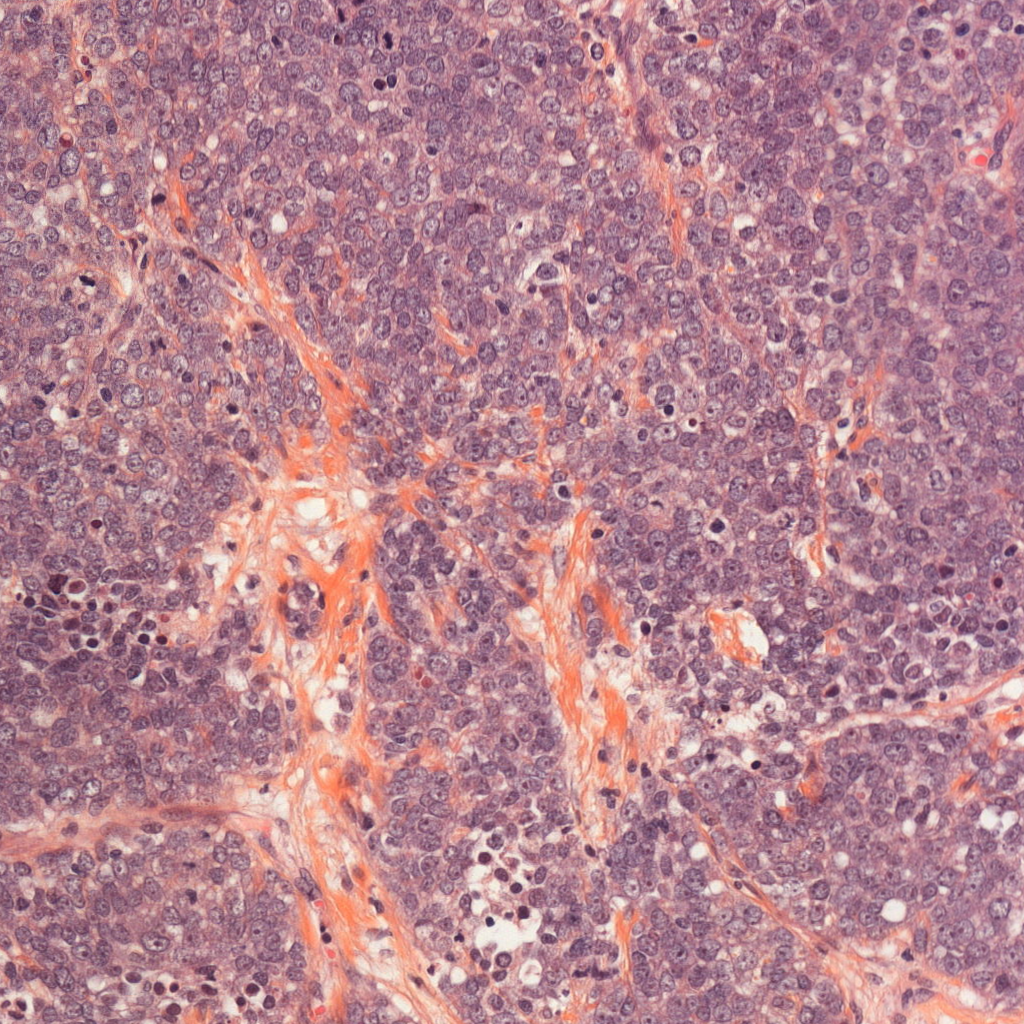

In [ ]:
patch = files.filter(lambda x: x.stem == "CF_PACS08rescan_173-08C4030_51200_67584")[0]
patch = Image.open(patch)
patch

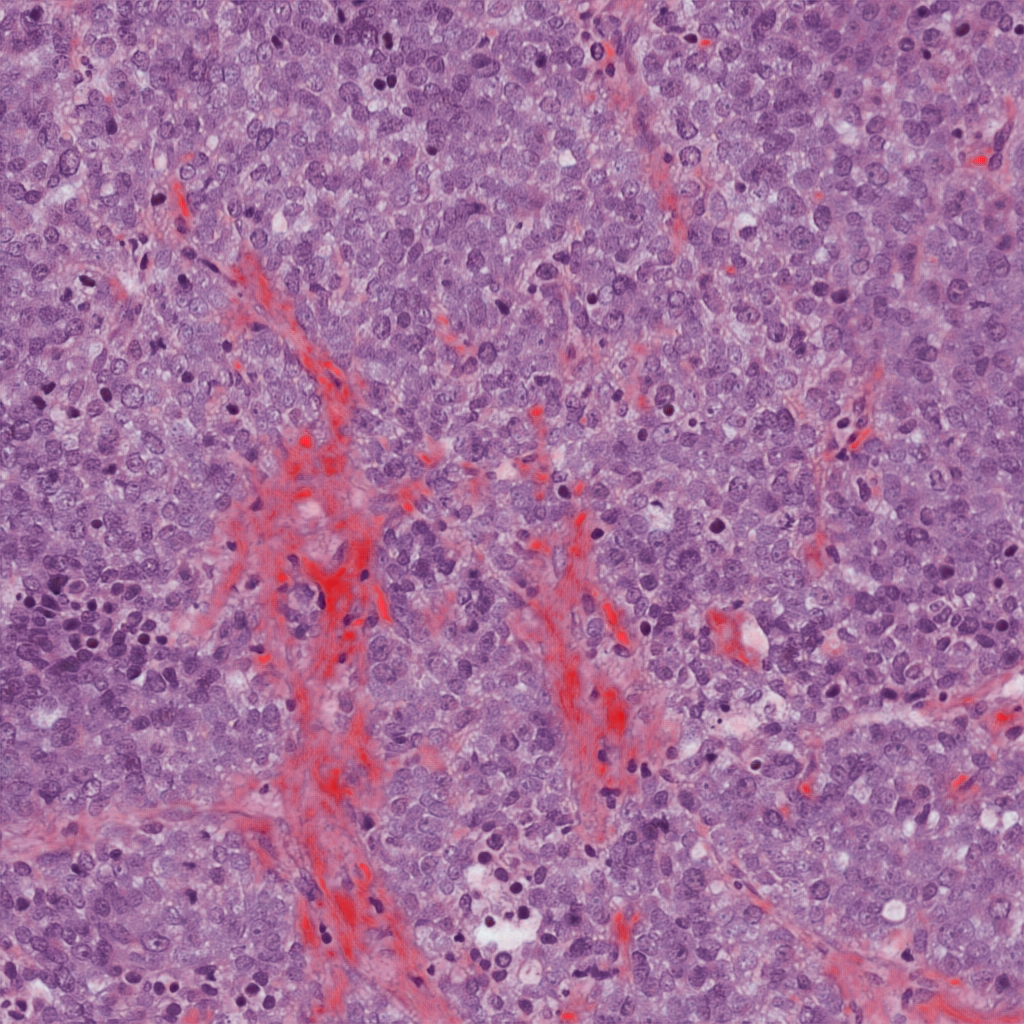

In [ ]:
x = to_tensor(patch)[None].to(device)
x = norm(x).clamp(0, 1).detach().cpu()
to_pil_image(x[0])

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(20, 20))
hists_base = {}
hists_norm = {}
for pacs in pacs_files:
    hists_base[pacs] = {c: np.zeros(256, dtype=np.float64) for c in "rgb"}
    hists_norm[pacs] = {c: np.zeros(256, dtype=np.float64) for c in "rgb"}
    ds = TestDataset(L(pacs_files[pacs].tolist()))
    dl = DataLoader(ds, batch_size=8, num_workers=8, pin_memory=True)
    for x in tqdm(dl):
        imgs = (x.numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
        with torch.no_grad():
            x = norm(x.to(device)).clamp(0, 1)
        norm_imgs = (x.cpu().numpy() * 255).astype(np.uint8).transpose(0, 2, 3, 1)
        for img, norm_img in zip(imgs, norm_imgs):
            mask = (cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) > 220).astype(np.uint8)
            mask_norm = (cv2.cvtColor(norm_img, cv2.COLOR_RGB2GRAY) > 220).astype(np.uint8)
            for i, chan in enumerate("rgb"):
                hist = cv2.calcHist([img], [i], mask, [256], [0, 256]).squeeze(1)
                hist = hist.astype(np.float64) / img[..., 0].size
                hists_base[pacs][chan] += hist
                hist = cv2.calcHist(
                    [norm_img], [i], mask_norm, [256], [0, 256]
                ).squeeze(1)
                hist = hist.astype(np.float64) / norm_img[..., 0].size
                hists_norm[pacs][chan] += hist
        for chan in "rgb":
            hists_base[pacs][chan] /= hists_base[pacs][chan].sum()
            hists_norm[pacs][chan] /= hists_norm[pacs][chan].sum()

  0%|          | 0/24659 [00:00<?, ?it/s]

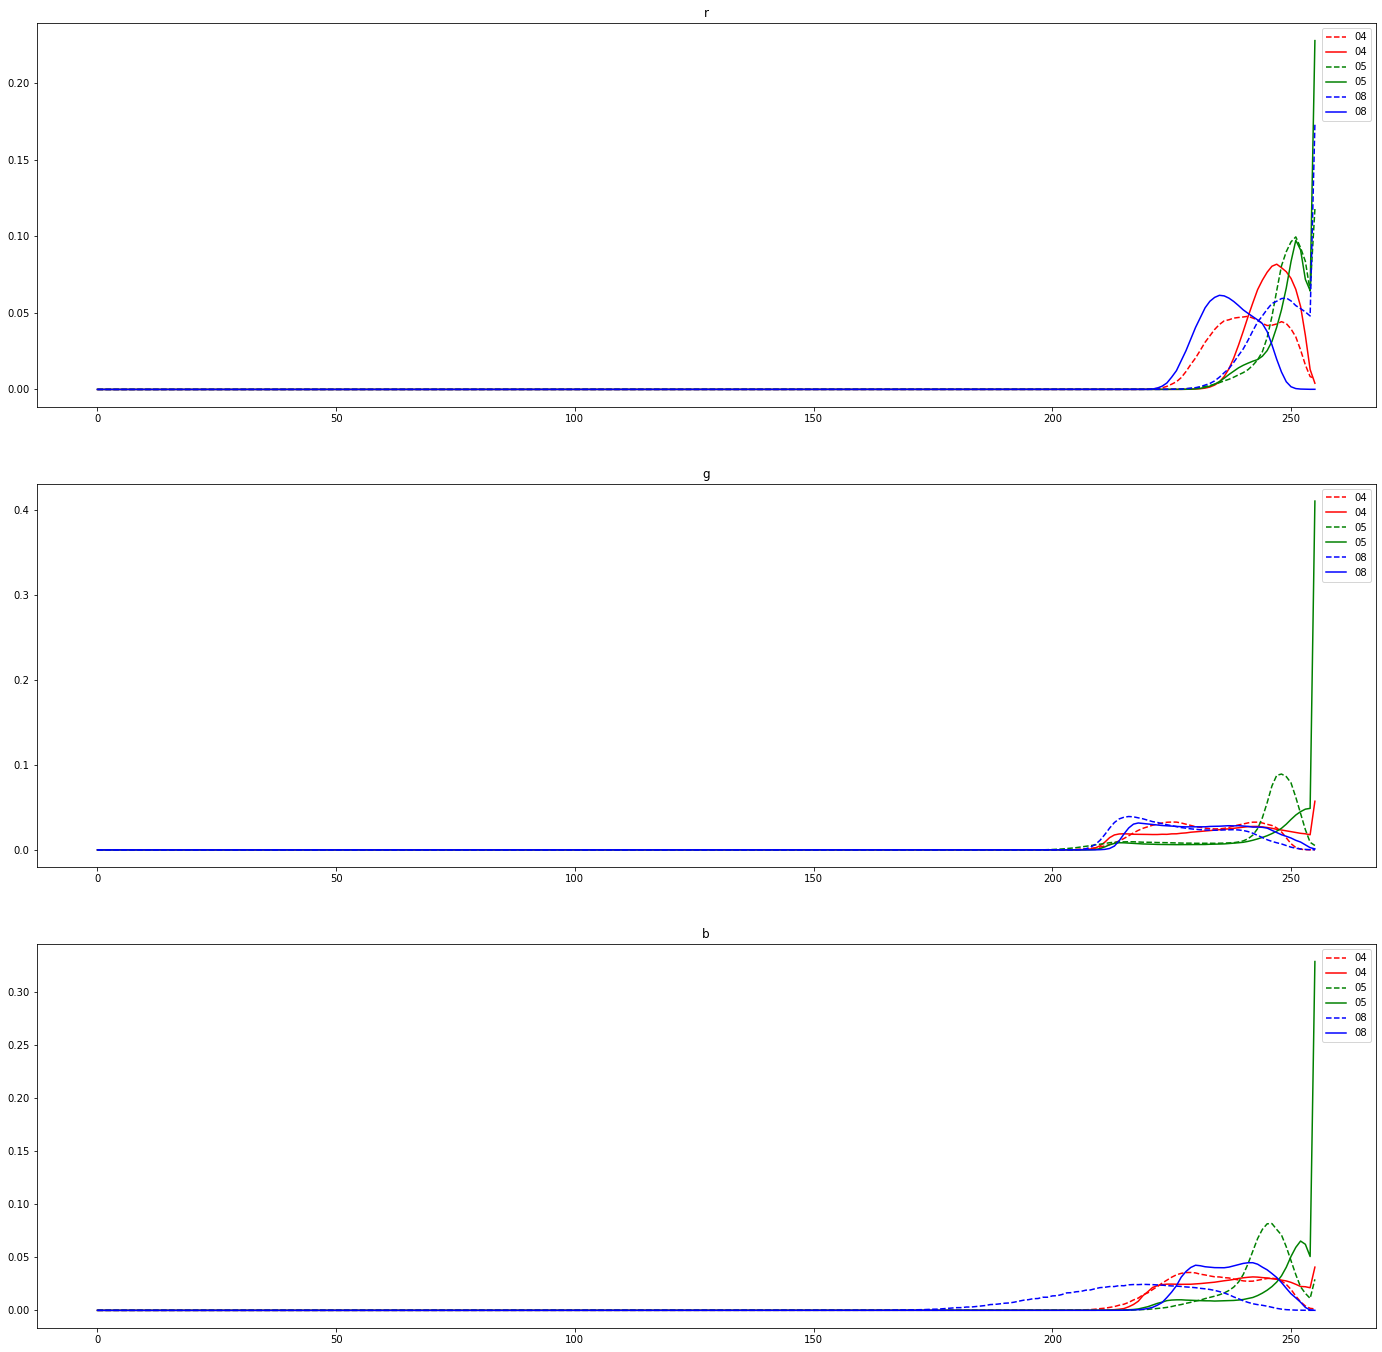

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(24, 24))
bins = np.arange(256)
for pacs, ax, col in zip(hists_base, axs, "rgb"):
    for hists_pacs, ls in zip((hists_base, hists_norm), ("--", "-")):
        hists = hists_pacs[pacs]
        for c, ax in zip(hists, axs):
            hist = hists[c]
            ax.plot(bins, hist, col+ls, label=pacs)
            ax.legend()
            ax.set_title(c)

In [ ]:
classes = ["1", "3"]
n_classes = len(classes)
model_name = "resnet50"
level = 1
version = "6f66daa8099243db81dca6f5a69a68a7"
save_path = Path(f"/data/DeepLearning/SCHWOB_Robin/models/logs/level_{level}/classifier/{model_name}/lightning_logs/version_{version}")

In [ ]:
df = pd.read_csv(save_path/"preds/14.csv")

In [ ]:
df.head()

In [ ]:
items = np.vectorize(Path)(df.values[:, 0])
preds = torch.as_tensor(df.values[:, 2:].astype(np.float32))
labels = torch.as_tensor(df.values[:, 1].astype(int))

In [ ]:
df = pd.read_csv("/data/DeepLearning/SCHWOB_Robin/Patches_FLFH_299/scan_splits.csv")

In [ ]:
items = get_files(
    "/data/DeepLearning/SCHWOB_Robin/Patches_cancer_1024/Patches_cancer_1024_1",
    extensions=[".png"],
).filter(lambda x: "PACS04" not in x.name)

In [ ]:
device = torch.device("cuda:1")

In [ ]:
model = torch.jit.load(
    str(save_path / "best_model.pt"),
    map_location=device,
).eval()

In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
ds = TestDataset(items, norm_method="vahadane", norm_ref="/data/DeepLearning/SCHWOB_Robin/CF_Normacolor_0182_41472_67392.png")

In [ ]:
dl = DataLoader(ds, batch_size=8, num_workers=8, pin_memory=True, shuffle=False, drop_last=False)

In [ ]:
labels = items.map(lambda x: x.parts[-3])

In [ ]:
labels = torch.as_tensor(np.array(labels) == "3").long()

In [ ]:
preds = []
for x in tqdm(dl):
    x = x.to(device, non_blocking=True)
    with torch.cuda.amp.autocast():
        y = model(x).detach()
        y = torch.softmax(y, dim=1)
    preds.append(y.cpu())
preds = torch.cat(preds)

In [ ]:
preds_np = preds.numpy()
labels_np = labels.numpy()
items_str = np.array(items).astype(str)
data = {
    f"pred_{classes[k]}": preds_np[:, k]
    for k in range(preds_np.shape[1])
}
data["item"] = items_str[: labels.shape[0]]
data["label"] = labels_np
keys = ["item", "label"] + [f"pred_{cl}" for cl in classes]
df = pd.DataFrame(data=data, columns=keys)
df.to_csv(save_path / "preds/test.csv", index=False)

In [ ]:
roc = ROC(num_classes=n_classes)

In [ ]:
fpr, tpr, thrs = roc(preds, labels)

In [ ]:
k = torch.argmin(fpr[-1]**2+(1-tpr[-1])**2)
best_thr = thrs[-1][k].item(); best_thr, fpr[-1][k], tpr[-1][k]

In [ ]:
plt.plot(fpr[-1].cpu(), tpr[-1].cpu())

In [ ]:
auc(fpr[-1], tpr[-1])

In [ ]:
cm = ConfusionMatrix(n_classes, threshold=best_thr, normalize="true")
metrics = ClassifMetrics(n_classes, threshold=best_thr)

In [ ]:
mat = cm(preds[:, -1], labels)
metric_dict = metrics(preds[:, -1], labels)

In [ ]:
cm_plot = ConfusionMatrixDisplay(mat.numpy(), display_labels=classes)

In [ ]:
cm_plot.plot(cmap=plt.cm.Blues)

In [ ]:
patch_slides = np.vectorize(lambda x: x.parent.name)(items)
slides = np.unique(patch_slides)

In [ ]:
slides = slides[np.vectorize(lambda x: "PACS05" in x)(slides)]

In [ ]:
slide_roc = ROC(num_classes=n_classes, compute_on_step=False)

In [ ]:
slide_labels = []
slide_preds = []
for slide in slides:
    idxs = np.argwhere(patch_slides == slide).squeeze()
    label = labels[idxs][0]
    pred = preds[idxs].mean(0)
    slide_roc(pred[None], label[None])
    slide_labels.append(label)
    slide_preds.append(pred)
slide_labels = torch.stack(slide_labels)
slide_preds = torch.stack(slide_preds)

In [ ]:
fpr, tpr, thrs = slide_roc.compute()

In [ ]:
k = torch.argmin(fpr[-1]**2+(1-tpr[-1])**2)
best_thr = thrs[-1][k].item(); best_thr, fpr[-1][k], tpr[-1][k]

In [ ]:
plt.plot(fpr[-1].cpu(), tpr[-1].cpu())
plt.title(f"AUC={auc(fpr[-1], tpr[-1]):.3f}")
plt.show()

In [ ]:
cm = ConfusionMatrix(n_classes, threshold=0.5, normalize="true")
metrics = ClassifMetrics(n_classes, threshold=0.5)

In [ ]:
mat = cm(slide_preds[:, -1], slide_labels)
metric_dict = metrics(slide_preds[:, -1], slide_labels)

In [ ]:
cm_plot = ConfusionMatrixDisplay(mat.numpy(), display_labels=classes)

In [ ]:
(slide_labels == 1).sum(), (slide_labels == 0).sum()

In [ ]:
cm_plot.plot(cmap=plt.cm.Blues)

In [ ]:
metric_dict

In [ ]:
for pacs in ("05", "08"):
    idxs = np.argwhere(np.vectorize(lambda x: x[7:9])(slides) == pacs).squeeze(1)
    print(len(idxs), len(np.argwhere(slide_labels[idxs] == 1).squeeze()))

In [ ]:
idxs = torch.nonzero((slide_preds[:, -1] >= 0.5).long() != slide_labels, as_tuple=False).squeeze()
print(len(idxs), len(slides)) 
print('\n'.join([f"{slide}-{classes[cl]}-{pred[1]:.3f}" for slide, cl, pred in zip(slides[idxs], slide_labels[idxs], slide_preds[idxs])]))

In [ ]:
k = 0

In [ ]:
slide = slides[k]

In [ ]:
slide

In [ ]:
patches = items[patch_slides == slide]

In [ ]:
slide_preds = preds[patch_slides == slide, slide_labels[k]]

In [ ]:
slide_labels[k]

In [ ]:
plt.figure(figsize=(10, 10))
x_coords = np.vectorize(lambda x: int(x.stem.split("_")[-2]) // 2048)(patches)
y_coords = np.vectorize(lambda x: int(x.stem.split("_")[-1]) // 2048)(patches)
h = max(y_coords) - min(y_coords) + 1
w = max(x_coords) - min(x_coords) + 1
thumb = OpenSlide(
    f"/home/DeepLearning/media/Isilon_robin/annot13/{slide}.mrxs"
).get_thumbnail((w * 128, h * 128))
mask = np.zeros((h, w), dtype=float)
mask[(y_coords, x_coords)] = slide_preds
mask = resize(mask, thumb.height, thumb.width)
# mask = (mask*255).astype(np.uint8)
plt.axis("off")
plt.imshow(mask, cmap="viridis")

In [ ]:
files = get_files(
    "/data/DeepLearning/SCHWOB_Robin/Patches_oncograde_1024/",
    extensions=[".png"],
)
files

In [ ]:
files = files.filter(lambda x: x.parent.name not in s); files

In [ ]:
class TestDataset(Dataset):
    def __init__(self, items):
        self.items = items.map(str)
        
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, idx):
        item = self.items[idx]
        img = imread(item).astype(np.float32)
        return np_to_tensor(img / 255, "image")

In [ ]:
ds = TestDataset(files)

In [ ]:
dl = DataLoader(
    ds, batch_size=8, shuffle=False, num_workers=8, drop_last=False, pin_memory=True
)

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = torch.jit.load(
    "/data/DeepLearning/SCHWOB_Robin/models/logs/level_1/classifier/resnet34/lightning_logs/version_30e0285c100b4a5392ad238d42066814/best_model.pt",
    map_location=device,
).eval()

In [ ]:
for p in model.parameters():
    p.requires_grad = False

In [ ]:
preds = []
for x in tqdm(dl):
    x = x.to(device, non_blocking=True)
    with torch.cuda.amp.autocast():
        y = model(x).detach()
        y = torch.softmax(y, dim=1)
    preds.append(y.cpu())
preds = torch.cat(preds)

In [ ]:
patch_slides = np.array(files.map(lambda x: x.parent.name))
slides = np.unique(patch_slides)

In [ ]:
slide_preds = []
for slide in slides:
    if slide in s:
        continue
    idxs = np.argwhere(patch_slides == slide).squeeze(1)
    pred = preds[idxs].mean(0)
    print(f"{slide}: pred={pred[1]:.3f}")
    slide_preds.append(pred)
slide_preds = torch.stack(slide_preds)

In [ ]:
preds = preds.numpy()
items = np.array(files).astype(str)
data = {
    f"pred_{classes[k]}": preds[:, k]
    for k in range(preds.shape[1])
}
data["item"] = items[: labels.shape[0]]
keys = ["item"] + [f"pred_{cl}" for cl in classes]
df = pd.DataFrame(data=data, columns=keys)
savepath = Path("/data/DeepLearning/SCHWOB_Robin/models/logs/level_1/classifier/resnet34/lightning_logs/version_30e0285c100b4a5392ad238d42066814/preds")
df.to_csv(savepath / "oncograde_best.csv", index=False)

In [ ]:
preds = L(preds)

In [ ]:
colors = np.array([[0, 0, 255],
                   [255, 0, 0],
                   [0, 255, 0]])

In [ ]:
all_slides = files.map(lambda x: x.parent.name)

In [ ]:
slides = all_slides.unique()

In [ ]:
all_slides = np.array(all_slides)

In [ ]:
ncols = 3
nrows = int(np.ceil(len(slides) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*8))
for ax, slide in tqdm(zip(axs.flatten(), slides), total=len(slides)):
    idxs = np.argwhere(all_slides == slide)
    slide_preds = preds[idxs]
    slide_files = files[idxs]
    x_coords = slide_files.map(lambda x: int(x.stem.split('_')[-2])//598)
    y_coords = slide_files.map(lambda x: int(x.stem.split('_')[-1])//598)
    h = max(y_coords) + 1
    w = max(x_coords) + 1
    mask = np.zeros((h, w, 3), dtype = np.uint8)
    mask[(y_coords, x_coords)] = colors[slide_preds]
    ax.axis("off")
    ax.set_title(slide)
    ax.imshow(mask)

In [ ]:
#df = pd.read_csv(hparams.patch_classes, index_col='patchId')
def get_filt(ds):
    def filt(x):
        return ds in x.stem
    return filt

In [ ]:
p04_items, p04_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS04'))

In [ ]:
p05_items, p05_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS05'))

In [ ]:
p08_items, p08_labels = get_items(hparams.data, lambda x: x.parts[-3], extensions=['.png'], filterfunc = get_filt('PACS08'))

In [ ]:
hparams.open_mode = 'H'
hparams.transforms = 1
hparams.model = 'cbr_5_32_4'
#hparams.loss = 'mse'
hparams.size = 299
hparams.gpus = [0]
hparams.filt = 'all'
hparams.batch_size = 16
hparams.patch_classes = None
hparams.norm_csv = None
hparams.concept_classes = None
hparams.level = 2
hparams.loss = 'mse'
# hparams.train_percent = 0.01
hparams.datafolder = Path('/data/DeepLearning/SCHWOB_Robin/Patches_normacolor_299/Patches_299_4')
hparams.data_csv = Path('/home/DeepLearning/grade_classif/csvs/normacolor_scans.csv')

In [ ]:
norm = Normalizer(hparams)

In [ ]:
dm = NormDataModule(hparams)

In [ ]:
dm.setup()

In [ ]:
norm.fit(dm)

In [ ]:
norm.load('1371a8451df344689f213e8db008ed71')

In [ ]:
norm.freeze()

In [ ]:
dm.data.valid._ds.items = p04_items
dm.data.valid._ds.labels = p04_items

In [ ]:
norm.data.test = norm.data.valid

In [ ]:
len(dm.data.valid)

In [ ]:
l = np.random.randint(len(dm.data.valid), size=64)

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(40, 40))
for n, ax1 in enumerate(axs):
    x = []
    for i in range(8):
        k = l[8*n+i]
        img, _ = dm.data.valid[k]
        x.append(img)
    x = torch.stack(x).to(norm.main_device)
    #x = _open_functions[norm.hparams.open_mode](x)
    x = norm.predict(x).detach().clamp(0, 1)
    x = x.cpu().numpy().transpose(0, 2, 3, 1)
    for im, ax in zip(x, ax1):
        ax.imshow(im)
        ax.axis('off')

In [ ]:
fig, axs = plt.subplots(8, 8, figsize=(40, 40))
for n, ax in enumerate(axs.flatten()):
    k = l[n]
    _, img = dm.data.valid[k]
    img = img.cpu().numpy().transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')

In [ ]:
norm.show_results(16, 6)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(24, 16))
fn = np.random.choice(p08_items)
x = loader(fn)[362:661, 362:661]
axs[0, 0].imshow(x)
axs[0, 0].axis('off')
for ax in axs.flatten()[1:]:
    x = rgb2hed(x)[..., 0].astype(np.float32)
    x = (x + 0.7) / 0.46
    x = np.stack((x, x, x), axis=-1)
    x = np_to_tensor(x, 'image')[None]
    x = x.to(norm.main_device)
    x = norm.predict(x).detach().clamp(0, 1)
    x = x.cpu().numpy().transpose(0, 2, 3, 1)[0]
    ax.imshow(x)
    ax.axis('off')

In [ ]:
from albumentations import CenterCrop

In [ ]:
patch_classes_df = pd.read_csv('/data/DeepLearning/SCHWOB_Robin/Patches_1024/Patches_1024_1/patch_classes.csv', index_col='patchId')
def filt(x):
    return patch_classes_df.loc[x.stem, 'type'] == 'K'

data = (ImageClassifDataset.
        from_folder(Path('/data/DeepLearning/SCHWOB_Robin/Patches_299/Patches_299_1/'), lambda x: x.parts[-3], classes=['1', '3'], extensions=['.png'], open_mode='RGB').
        split_by_csv(hparams.data_csv.parent/'scans.csv').
        to_tensor(tfm_y=False))

In [ ]:
fig, axs = plt.subplots(8, 2, figsize=(10, 40))
batch = []
for _ in axs:
    i = np.random.randint(len(data.train))
    im, _ = data.train[i]
    batch.append(im)
x = torch.stack(batch).to(norm.main_device)
y = norm.predict(x).clamp(0, 1).detach().cpu()
for ax, im, pred in zip(axs, batch, y):
    im = im.numpy().transpose(1, 2, 0)
    pred = pred.numpy().transpose(1, 2, 0)
    ax[0].imshow(im)
    ax[0].axis('off')
    ax[1].imshow(pred)
    ax[1].axis('off')